Loading Data

In [ ]:
https://github.com/lucaseo/kaggle-walmart-triptype-classification/blob/master/project-report.ipynb

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/submission.csv')

Exploratory Data Analysis

In [ ]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


UPC number are the digits referring to the barcode and FinelineNumber is like an internal dept code allocated by Walmart. Right now i'll omit these features, as it might require some research and feature engineering to utilize them for my model

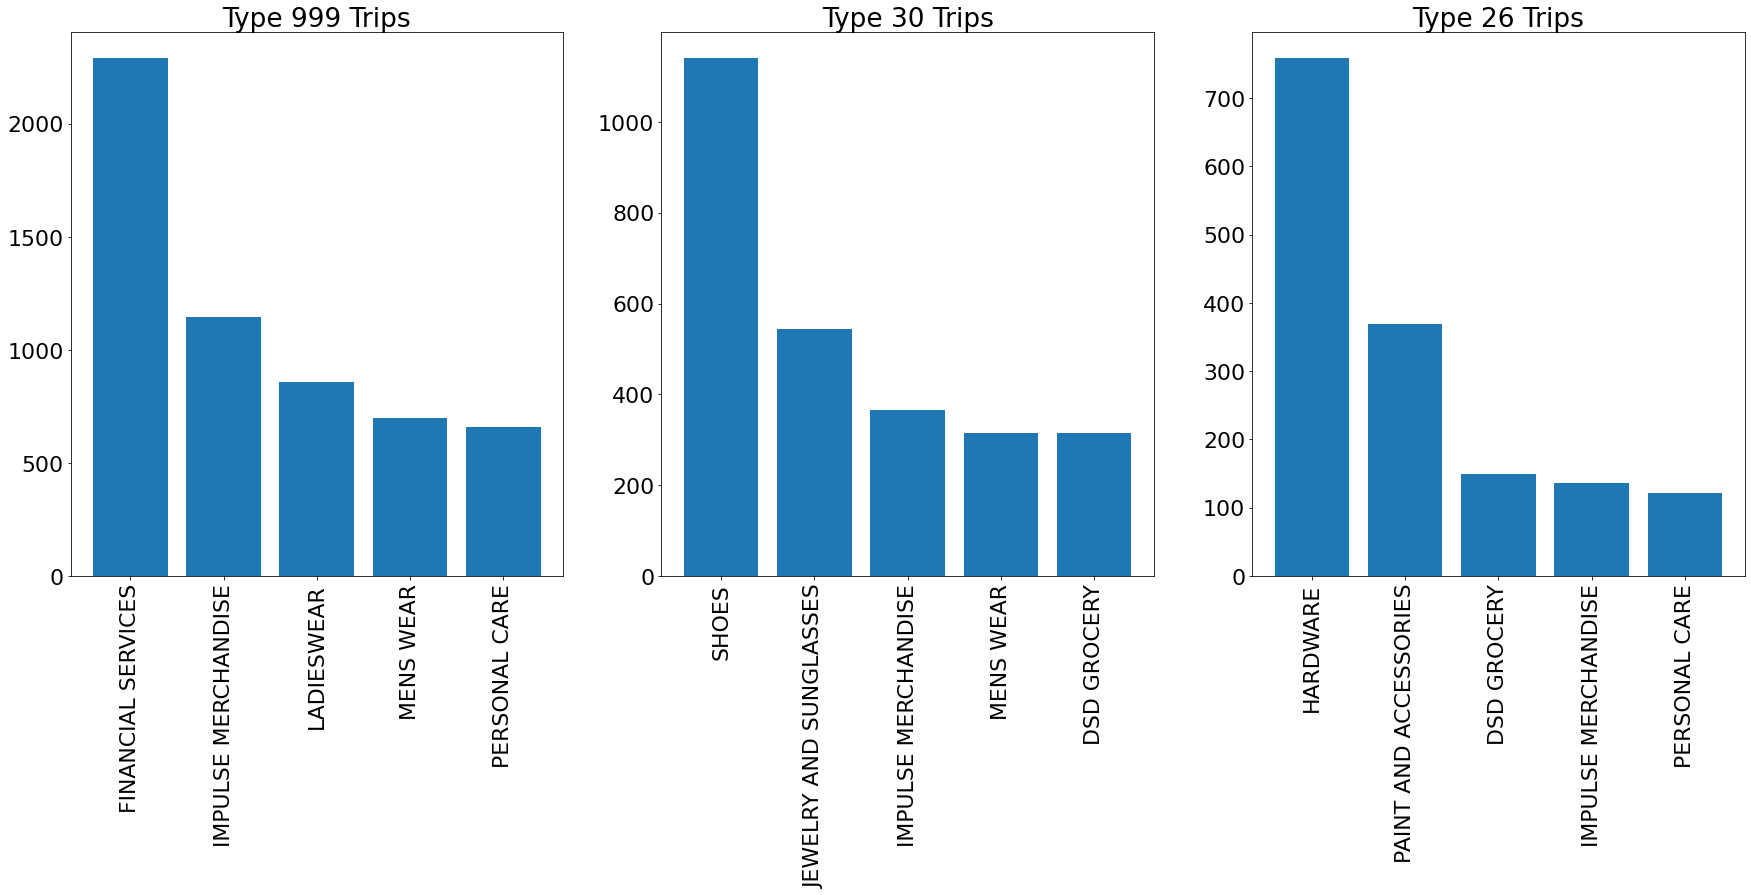

In [ ]:
# Checking what are the top 5 departments are involved in each triptype

# plot settings : figsize and font size
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})

# looping over each trip type and finding top 5 depts assosciated
for j, i in enumerate(train.TripType.unique()):
    if j > 2: #im limiting to 3 plots
        break
    type_x = train[train.TripType == i]
    type_items = type_x[["TripType","DepartmentDescription"]]
    x = type_items.DepartmentDescription.value_counts().head()
    plt.subplot(1, 3, j+1)
    plt.bar(x.index, x.values)
    plt.xticks(rotation=90)
    plt.title(f"Type {i} Trips")

It seems like the top 5 items are closely related, lets plot a heatmap to check further

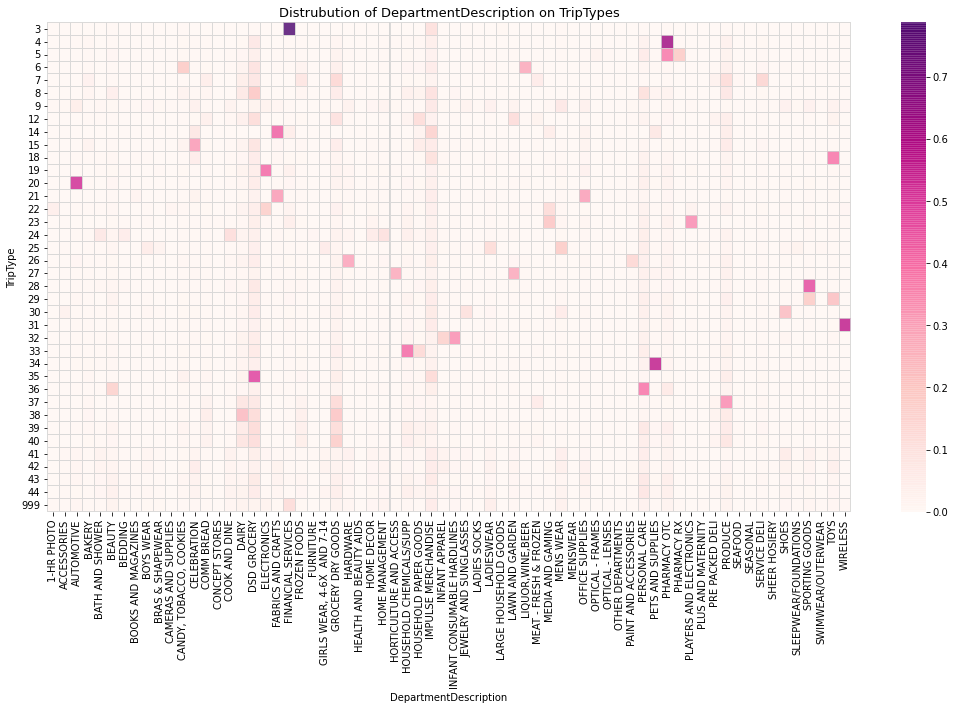

In [ ]:
# crosstable of Triptype vs DeptDesc
trip_desc = pd.crosstab(train["TripType"], 
                        train["DepartmentDescription"], 
                        values=train["ScanCount"], 
                        aggfunc="count", 
                        normalize="index")

# heatmap
plt.figure(figsize=(18, 9))
plt.rcParams.update({'font.size': 10})
seaborn.heatmap(trip_desc, linecolor="lightgrey", linewidths=0.02, cmap="RdPu", alpha=.8)
plt.title("Distrubution of DepartmentDescription on TripTypes", fontsize=13)
plt.show()

In [ ]:
# checking all categories
print( train.DepartmentDescription.nunique(), '\n', train.DepartmentDescription.unique() )

68 
 ['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS'
 'CELEBRATION' 'HARDWARE' 'BEAUTY' 'AUTOMOTIVE' 'BOOKS AND MAGAZINES'
 'SEAFOOD' 'OFFICE SUPPLIES' 'LAWN AND GARDEN' 'SHEER HOSIERY' 'WIRELESS'
 'BEDDING' 'BATH AND SHOWER' 'HORTICULTURE AND ACCESS' 'HOME DECOR' 'TOYS'
 'INFANT APPAREL' 'LADIES SOCKS' 'PLUS AND MATERNITY' 'ELECTRONICS'
 'GIRLS WEAR, 4-6X  AND 7-14' 'BRAS & SHAPEWEAR' 'LIQUOR,WINE,BEER'
 'SLEEPWEAR/FOUNDATIONS' 'CAMERAS AND SUPPLIES' 'SPORTING GOODS'
 'PLAYERS AND ELECTRONICS' 'PHARMACY RX' 'MENSWEAR' '

In [ ]:
# checking all categories
print( test.DepartmentDescription.nunique(), '\n', test.DepartmentDescription.unique() )

67 
 ['SHOES' 'DAIRY' 'GROCERY DRY GOODS' 'DSD GROCERY' 'BAKERY'
 'IMPULSE MERCHANDISE' 'PERSONAL CARE' 'FABRICS AND CRAFTS' 'BOYS WEAR'
 'PRE PACKED DELI' 'MENS WEAR' 'CELEBRATION' 'HOUSEHOLD CHEMICALS/SUPP'
 'FROZEN FOODS' 'PRODUCE' 'HOME MANAGEMENT' 'PHARMACY OTC'
 'CANDY, TOBACCO, COOKIES' 'HOUSEHOLD PAPER GOODS' 'SPORTING GOODS'
 'HARDWARE' 'COMM BREAD' 'HOME DECOR' 'COOK AND DINE' 'SERVICE DELI'
 'PETS AND SUPPLIES' 'MEAT - FRESH & FROZEN' 'FINANCIAL SERVICES'
 'SEAFOOD' 'WIRELESS' 'MEDIA AND GAMING' 'PAINT AND ACCESSORIES'
 'LADIESWEAR' 'SLEEPWEAR/FOUNDATIONS' 'BEAUTY' 'BRAS & SHAPEWEAR'
 'FURNITURE' 'LAWN AND GARDEN' 'AUTOMOTIVE' 'BATH AND SHOWER'
 'ELECTRONICS' 'OFFICE SUPPLIES' 'INFANT CONSUMABLE HARDLINES'
 'GIRLS WEAR, 4-6X  AND 7-14' 'INFANT APPAREL' 'LIQUOR,WINE,BEER' nan
 'BOOKS AND MAGAZINES' 'HORTICULTURE AND ACCESS' 'JEWELRY AND SUNGLASSES'
 'ACCESSORIES' 'LADIES SOCKS' 'BEDDING' 'TOYS' 'OPTICAL - FRAMES'
 'PHARMACY RX' 'CAMERAS AND SUPPLIES' 'MENSWEAR' 'PLAYERS AND E

'HEALTH AND BEAUTY AIDS' does not exist in test data, will drop it from train too to match shape

Preprocessing pipeline

In [3]:
def preprocess_1(df):

  # dropping UPC and FNNo, NAs 
  df.drop(['Upc','FinelineNumber'], axis=1, inplace=True)
  df = df.dropna()

  # one hot encoding deptdesc
  temp_dd = pd.get_dummies(df['DepartmentDescription'])
  temp_dd = pd.concat([df[["VisitNumber"]], temp_dd], axis=1)
  temp_dd = temp_dd.groupby("VisitNumber", as_index=False).sum()

  return temp_dd

In [4]:
def preprocess_2(df):

  # encoding weekday
  df['Weekday'] = df['Weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5,"Saturday": 6, "Sunday": 7})
  
  # creating a return column
  df.loc[df.ScanCount < 0, 'Return'] = 1
  df.loc[df.Return != 1, 'Return'] = 0

  # Sum of positive negative purchases
  df["Pos_Sum"] = df["ScanCount"]
  df.loc[df["Pos_Sum"] < 0, "Pos_Sum"] = 0
  df["Neg_Sum"] = df["ScanCount"]
  df.loc[df["Neg_Sum"] > 0, "Neg_Sum"] = 0

  return df

In [10]:
def preprocess_3(df): 
  
  # groupby and aggregation on 'Visitnumber'
  df_by_sum = df[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]] # remove pos neg if multiply with scancount
  df_by_sum = df_by_sum.groupby("VisitNumber", as_index=False).sum()
  df_by_max = df[["TripType", "VisitNumber", "Weekday", "Return"]]
  df_by_max = df_by_max.groupby("VisitNumber", as_index=False).max()
  df = df_by_sum.merge(df_by_max, on=["VisitNumber"])

  return df

In [5]:
def preprocess_3_alt(df): 
  
  # groupby and aggregation on 'Visitnumber'
  df_by_sum = df[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]] # remove pos neg if multiply with scancount
  df_by_sum = df_by_sum.groupby("VisitNumber", as_index=False).sum()
  df_by_max = df[[ "VisitNumber", "Weekday", "Return"]]
  df_by_max = df_by_max.groupby("VisitNumber", as_index=False).max()
  df = df_by_sum.merge(df_by_max, on=["VisitNumber"])

  return df

In [6]:
def preprocess_4(df1,df2): 
  
  df = df2.merge(df1, on=["VisitNumber"])
  # one hot encoding weekday and return
  df = pd.get_dummies(df, columns=["Weekday", "Return"])

  return df

In [7]:
pd.options.mode.chained_assignment = None
train = pd.read_csv('/content/train.csv')

one = preprocess_1(train)
one.head()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,16,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
two = preprocess_2(train)
two.head()

,TripType,VisitNumber,Weekday,ScanCount,DepartmentDescription,Return,Pos_Sum,Neg_Sum
0,999,5,5,-1,FINANCIAL SERVICES,1.0,0,-1
1,30,7,5,1,SHOES,0.0,1,0
2,30,7,5,1,PERSONAL CARE,0.0,1,0
3,26,8,5,2,PAINT AND ACCESSORIES,0.0,2,0
4,26,8,5,2,PAINT AND ACCESSORIES,0.0,2,0


In [11]:
three = preprocess_3(two)
three.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,TripType,Weekday,Return
0,5,-1,0,-1,999,5,1.0
1,7,2,2,0,30,5,0.0
2,8,28,30,-2,26,5,1.0
3,9,3,3,0,8,5,0.0
4,10,3,3,0,8,5,0.0


In [12]:
train_final = preprocess_4(one,three)
train_final.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,TripType,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,...,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,Return_0.0,Return_1.0
0,5,-1,0,-1,999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,7,2,2,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,8,28,30,-2,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,16,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,9,3,3,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,10,3,3,0,8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [13]:
train_final.shape

(95516, 82)

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

In [15]:
# data and label assignment
y = train_final["TripType"]
X = train_final.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)
# will decode later
label_enc = LabelEncoder().fit(y)
# convert random trip type number to series
y_labeled = label_enc.transform(y)

In [16]:
# mytrain, mytest = train_test_split(data_train, test_size = .2)
X_train, X_test, y_train, y_test = train_test_split(X, y_labeled, random_state=1)
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [17]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.2}

evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10,)

[0]	train-mlogloss:3.07756	eval-mlogloss:3.08796
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.58191	eval-mlogloss:2.60445
[2]	train-mlogloss:2.19512	eval-mlogloss:2.22932
[3]	train-mlogloss:1.91618	eval-mlogloss:1.95956
[4]	train-mlogloss:1.72937	eval-mlogloss:1.78005
[5]	train-mlogloss:1.59075	eval-mlogloss:1.64754
[6]	train-mlogloss:1.48153	eval-mlogloss:1.54346
[7]	train-mlogloss:1.39297	eval-mlogloss:1.46006
[8]	train-mlogloss:1.31923	eval-mlogloss:1.39171
[9]	train-mlogloss:1.25772	eval-mlogloss:1.3349
[10]	train-mlogloss:1.20514	eval-mlogloss:1.2869
[11]	train-mlogloss:1.1598	eval-mlogloss:1.24586
[12]	train-mlogloss:1.1209	eval-mlogloss:1.21106
[13]	train-mlogloss:1.08658	eval-mlogloss:1.18045
[14]	train-mlogloss:1.05593	eval-mlogloss:1.15358
[15]	train-mlogloss:1.02912	eval-mlogloss:1.13044
[16]	train-mlogloss:1.00497	eval-mlogloss:1.11033
[17]	train-ml

In [18]:
my_test = xgb.DMatrix(X_test.values)
test_predictions = bst.predict(my_test)
print("log loss :", log_loss(y_test, test_predictions).round(5))

log loss : 0.89423


In [19]:
yprob = test_predictions.reshape(y_test.shape[0], 38)
ylabel = np.argmax(yprob, axis=1)
accuracy = 100 *(1 - (sum(int(ylabel[i]) != y_test[i]
                         for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 69.28%


In [ ]:
test = pd.read_csv('/content/test.csv')

one = preprocess_1(test)
two = preprocess_2(test)
three = preprocess_3_alt(two)
test = preprocess_4(one,three)

vn = test[["VisitNumber"]]

test.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,Return_0.0,Return_1.0
0,1,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,2,4,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,3,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,6,0,1,-1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
classes = np.array(list(set(label_enc.inverse_transform(y_labeled))))

dmtest = xgb.DMatrix(test.values)
pred_proba = bst.predict(dmtest)

proba_df = pd.DataFrame(pred_proba, columns=classes)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([vn, proba_df], axis=1)

In [ ]:
sub_df.shape

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,TripType_18,TripType_19,TripType_20,TripType_21,TripType_22,TripType_23,TripType_24,TripType_25,TripType_26,TripType_27,TripType_28,TripType_29,TripType_30,TripType_31,TripType_32,TripType_33,TripType_34,TripType_35,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sub_df.to_csv("/content/fox_submission.csv", index=False)

In [ ]:
  # add column scancount to dummies
  # multiplying each entry with scancount
  # temp = temp.apply(lambda x: x*temp["ScanCount"])
  # temp.drop(['ScanCount'], axis=1, inplace=True)
  # temp = temp.groupby("VisitNumber", as_index=False).sum()

  # # combining multiplied dummies with df
  # # temp = pd.concat([df, temp], axis = 1)
  # # dropping deptdesc as we have temp columns
  # #temp.drop(['DepartmentDescription'], axis=1, inplace=True)